******************************
Applied Current -0.15830721003134796 A Time 0.517 hrs Capacity 81.84482758620689 mAh
Applied Current 0.15830721003134796 A Time 0.51 hrs Capacity 80.73667711598746 mAh
Negative : Positive electrode thickness 1.0
Total Charge/Discharge Time 1.0270000000000001 hrs
Total Capacity 162.582 mAh
Total Capacity 162.5622530178544 mAh.cm-3
******************************
Applied Current -0.15830721003134796 A Time 0.589 hrs Capacity 93.24294670846393 mAh
Applied Current 0.15830721003134796 A Time 0.594 hrs Capacity 94.03448275862068 mAh
Negative : Positive electrode thickness 1.15
Total Charge/Discharge Time 1.1829999999999998 hrs
Total Capacity 187.277 mAh
Total Capacity 175.55086274786368 mAh.cm-3
******************************
Applied Current -0.15830721003134796 A Time 0.628 hrs Capacity 99.41692789968651 mAh
Applied Current 0.15830721003134796 A Time 0.677 hrs Capacity 107.17398119122257 mAh
Negative : Positive electrode thickness 1.3
Total Charge/Discharge Tim

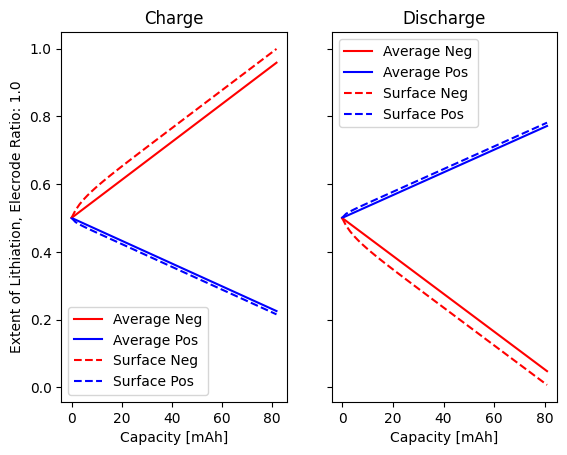

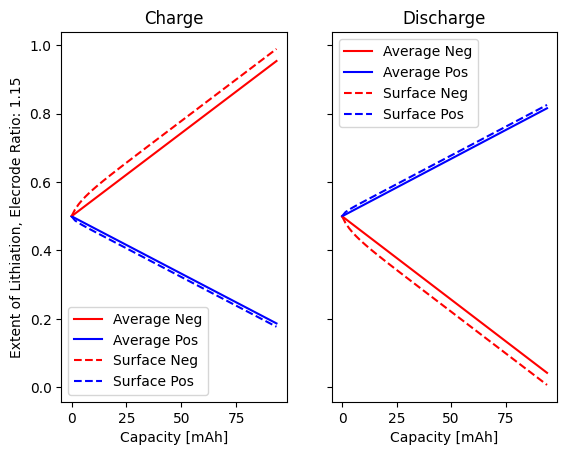

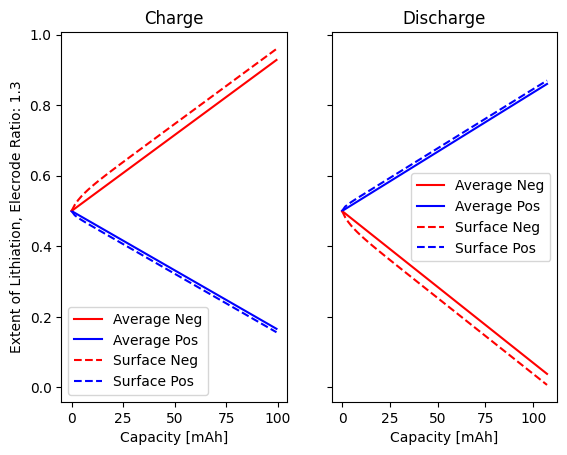

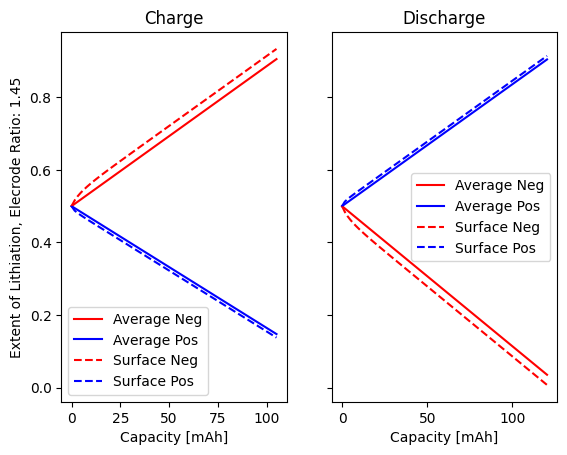

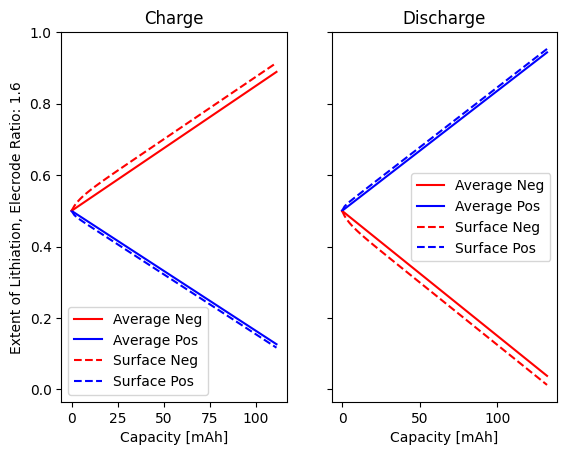

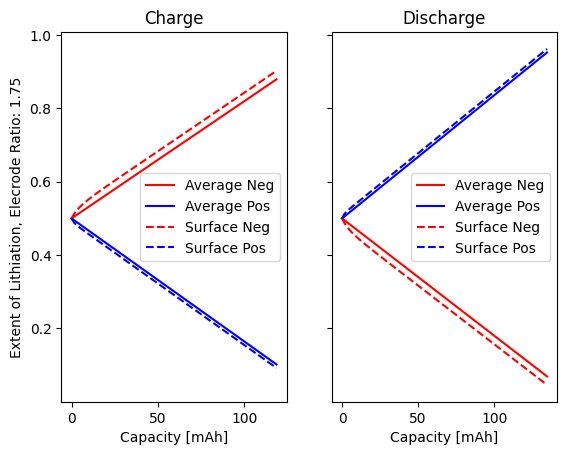

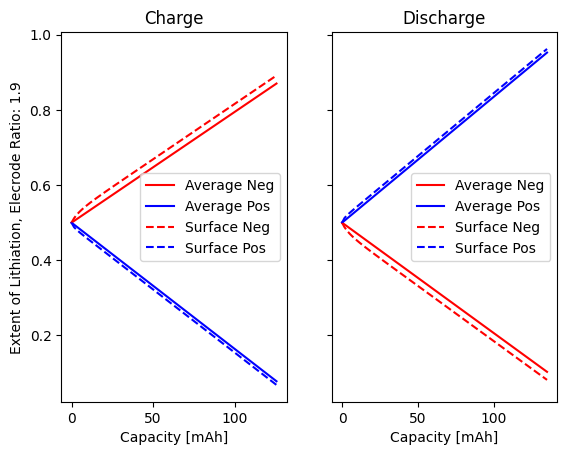

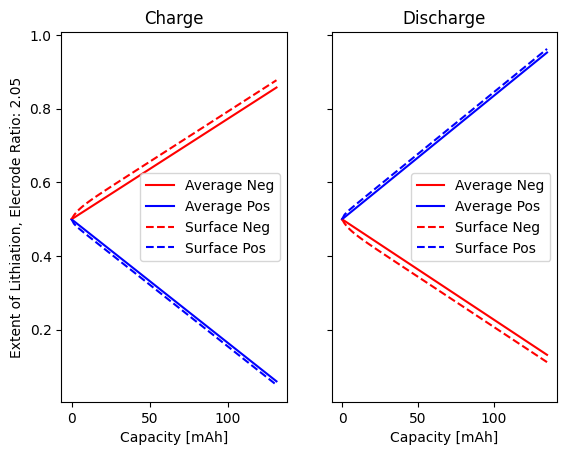

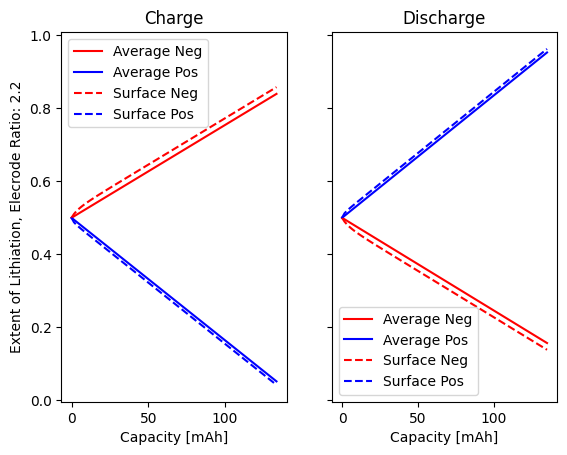

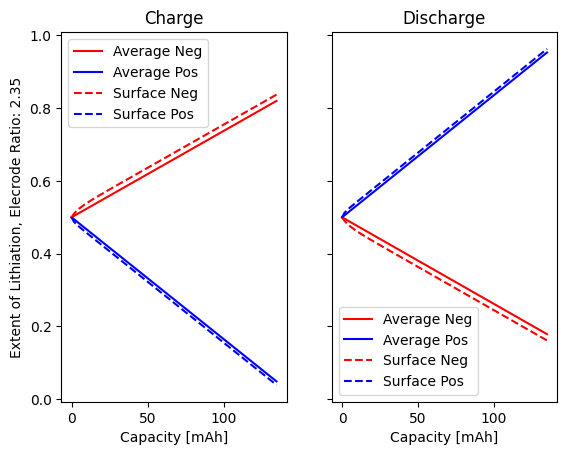

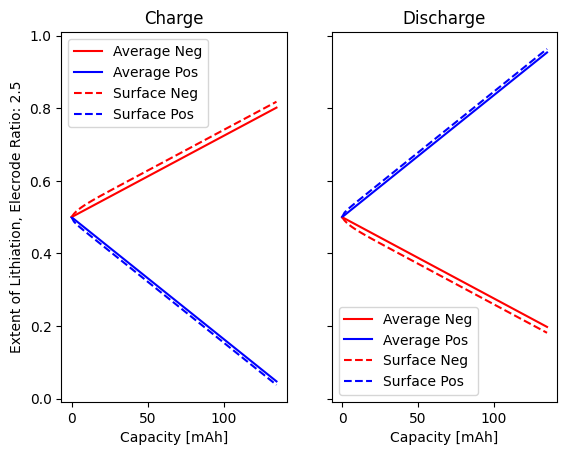

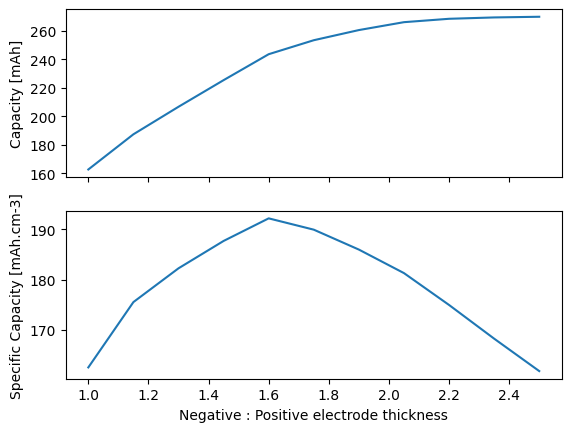

In [1]:
#
#  Example to show the state of charge of a battery using the SPMe model
#  Initial conditions are specified to start each electrode in 1/2 charged
#  state. A charge and discharge are performed with current chosen to be
#  1C rate when electrode dimensions are euqal.
#  Coulomb counting is performed to calculate the capacity of the
#  battery within the operating voltage limits and maximum particle concs.
#  The negative electrode thickness is varied to highlight the importance of electrode
#  sizing to enable full lithium utilization
#
import pybamm
import numpy as np
import matplotlib.pyplot as plt

factor = 6.38
capacities = []
specific_capacities = []
l_p = 1e-4
thicknesses = np.linspace(1.0, 2.5, 11) * l_p
for l_n in thicknesses:
    e_ratio = np.around(l_n / l_p, 3)
    # Dimensions
    h = 0.137
    w = 0.207 / factor
    A = h * w
    l_s = 2.5e-5
    l1d = l_n + l_p + l_s
    vol = h * w * l1d
    vol_cm3 = vol * 1e6
    tot_cap = 0.0
    tot_time = 0.0
    fig, axes = plt.subplots(1, 2, sharey=True)
    I_mag = 1.01 / factor
    print("*" * 30)
    for enum, I_app in enumerate([-1.0, 1.0]):
        I_app *= I_mag
        # load model
        model = pybamm.lithium_ion.SPMe()
        # create geometry
        geometry = model.default_geometry
        # load parameter values and process model and geometry
        param = model.default_parameter_values
        param.update(
            {
                "Electrode height [m]": h,
                "Electrode width [m]": w,
                "Negative electrode thickness [m]": l_n,
                "Positive electrode thickness [m]": l_p,
                "Separator thickness [m]": l_s,
                "Lower voltage cut-off [V]": 2.8,
                "Upper voltage cut-off [V]": 4.7,
                "Maximum concentration in negative electrode [mol.m-3]": 25000,
                "Maximum concentration in positive electrode [mol.m-3]": 50000,
                "Initial concentration in negative electrode [mol.m-3]": 12500,
                "Initial concentration in positive electrode [mol.m-3]": 25000,
                "Current function [A]": I_app,
            }
        )
        param.process_model(model)
        param.process_geometry(geometry)
        var_pts = {"x_n": 5, "x_s": 5, "x_p": 5, "r_n": 5, "r_p": 10}
        # set mesh
        mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)
        # discretise model
        disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
        disc.process_model(model)
        # solve model
        t_eval = np.linspace(0, 3600, 100)
        sol = model.default_solver.solve(model, t_eval)
        xpext = sol["X-averaged positive electrode extent of lithiation"]
        xnext = sol["X-averaged negative electrode extent of lithiation"]
        xpsurf = sol["X-averaged positive particle surface concentration"]
        xnsurf = sol["X-averaged negative particle surface concentration"]
        time = sol["Time [h]"]
        # Coulomb counting
        time_secs = sol["Time [s]"].entries
        time_hours = time(time_secs)
        dc_time = np.around(time_hours[-1], 3)
        # Capacity mAh
        cap = np.absolute(I_app * 1000 * dc_time)
        cap_time = np.absolute(I_app * 1000 * time_hours)
        axes[enum].plot(cap_time, xnext(time_secs), "r-", label="Average Neg")
        axes[enum].plot(cap_time, xpext(time_secs), "b-", label="Average Pos")
        axes[enum].plot(cap_time, xnsurf(time_secs), "r--", label="Surface Neg")
        axes[enum].plot(cap_time, xpsurf(time_secs), "b--", label="Surface Pos")
        axes[enum].set_xlabel("Capacity [mAh]")
        handles, labels = axes[enum].get_legend_handles_labels()
        axes[enum].legend(handles, labels)
        if I_app < 0.0:
            axes[enum].set_ylabel(
                "Extent of Lithiation, Elecrode Ratio: " + str(e_ratio)
            )
            axes[enum].title.set_text("Charge")
        else:
            axes[enum].title.set_text("Discharge")
        print(
            "Applied Current",
            I_app,
            "A",
            "Time",
            dc_time,
            "hrs",
            "Capacity",
            cap,
            "mAh",
        )
        tot_cap += cap
        tot_time += dc_time

    print("Negative : Positive electrode thickness", e_ratio)
    print("Total Charge/Discharge Time", tot_time, "hrs")
    print("Total Capacity", np.around(tot_cap, 3), "mAh")
    specific_cap = np.around(tot_cap, 3) / vol_cm3
    print("Total Capacity", specific_cap, "mAh.cm-3")
    capacities.append(tot_cap)
    specific_capacities.append(specific_cap)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(thicknesses / l_p, capacities)
ax2.plot(thicknesses / l_p, specific_capacities)
ax1.set_ylabel("Capacity [mAh]")
ax2.set_ylabel("Specific Capacity [mAh.cm-3]")
ax2.set_xlabel("Negative : Positive electrode thickness")
plt.show()
